# 주식 가격 예측


In [1]:
import sys
import random
import pickle

import pandas as pd
import numpy as np
import json
#from konlpy.tag import Twitter
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

/Users/yoo/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
import pandas as pd
import numpy as np
import math
import datetime

from sklearn import preprocessing, cross_validation, svm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

/Users/yoo/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading Dataset

In [6]:
# read train data
with open('./data/train_data.json') as fp:
    json_str = fp.read()
    json_data = json.loads(json_str)

In [9]:
train_df = pd.DataFrame(json_data, columns=['date','name','open','close','low','high','vol'])

In [10]:
with open('./data/grading.input.txt') as fp:
    sbm_in = fp.read()
    sbm_in = sbm_in.splitlines()

In [315]:
sbm_in

['teller',
 'winch',
 'bay',
 'admissions',
 'mules',
 'firearms',
 'horizons',
 'gross',
 'residues',
 'null',
 'flake',
 'outlets',
 'gardens',
 'navigator',
 'collector',
 'arguments',
 'mine',
 'steeple',
 'shoe',
 'weaves',
 'custody',
 'spark',
 'lines',
 'recommendations',
 'hundreds',
 'listings',
 'decontamination',
 'drivers',
 'closures',
 'bulkhead',
 'grades',
 'dimensions',
 'trunk',
 'rims',
 'detents',
 'incentive',
 'major',
 'flower',
 'multitask',
 'mistrials',
 'pavement',
 'market',
 'deputies',
 'cleansers',
 'variations',
 'purchasers',
 'consolidation',
 'schoolrooms',
 'gaskets',
 'letterhead',
 'speeders',
 'holds',
 'electricity',
 'skips',
 'injector',
 'tilling',
 'gangways',
 'distributors',
 'broadcasts',
 'spare',
 'formulas',
 'packages',
 'rake',
 'slice',
 'factor',
 'point',
 'geography',
 'observations',
 'candidates',
 'intake',
 'acids',
 'shores',
 'collisions',
 'tents',
 'helicopter',
 'staple',
 'observers',
 'servants',
 'question',
 'meal',


In [472]:
# teller_df = train_df[train_df['name']=='teller']
teller_df = train_df[train_df['name']=='speeders']

In [473]:
teller_df = teller_df.set_index('date')

In [474]:
print(teller_df.head(2).round(1))

                name  open  close   low  high       vol
date                                                   
2010-01-04  speeders  40.7   41.0  40.3  41.1   6880880
2010-01-05  speeders  40.8   40.9  40.3  41.3  10654597


In [475]:
teller_df['hl_pct'] = (teller_df['high'] - teller_df['low'])/(teller_df['low']*100)
teller_df['pct_chng'] = (teller_df['close'] - teller_df['open'])/(teller_df['open']*100)

In [476]:
teller_df.tail()

,name,open,close,low,high,vol,hl_pct,pct_chng
date,,,,,,,,
2016-12-22,speeders,75.043,74.422,74.676,75.212,2871206,0.000072,-0.000083
2016-12-23,speeders,74.766,75.056,74.847,75.137,1957788,0.000039,0.000039
2016-12-27,speeders,74.955,74.942,74.677,75.073,2046005,0.000053,-0.000002
2016-12-28,speeders,74.905,74.370,74.201,75.510,2515066,0.000176,-0.000071
2016-12-29,speeders,74.339,74.025,73.563,74.831,2574054,0.000172,-0.000042


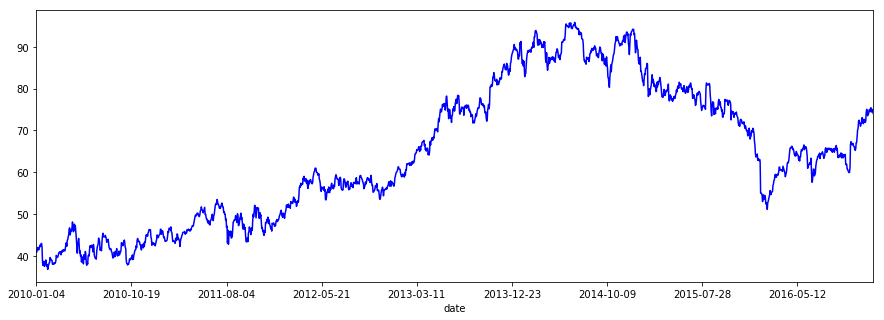

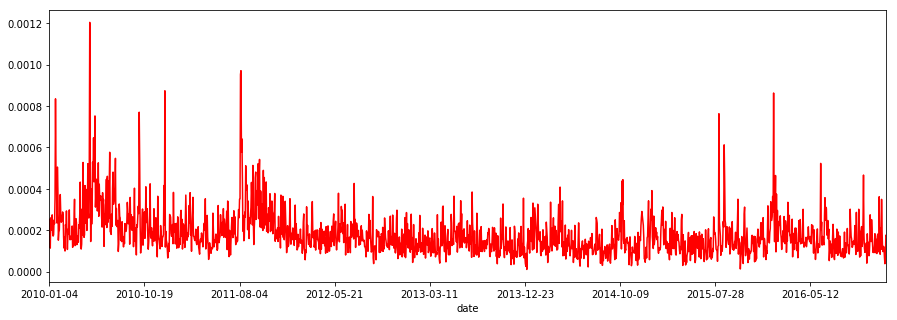

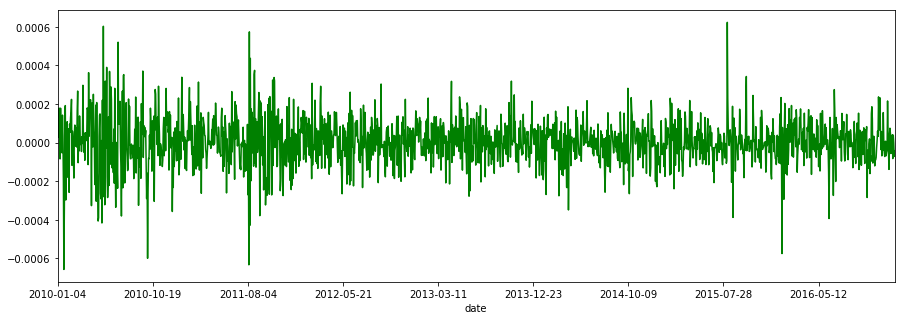

In [477]:
teller_df['close'].plot(figsize=(15,5), color='blue')
plt.show()

teller_df['hl_pct'].plot(figsize=(15,5), color='red')
plt.show()

teller_df['pct_chng'].plot(figsize=(15,5), color='green')
plt.show()

In [478]:
forecast_out = int(1)

In [479]:
# 예측 컬럼
forecast_col = 'close'

# 예측 기간 하루
forecast_out = int(1)

print('length =',len(teller_df), "and forecast_out =", forecast_out)

length = 1761 and forecast_out = 1


In [480]:
# forecast_out에 맞춰 label을 변경

teller_df['label'] = teller_df[forecast_col].shift(-forecast_out)


In [481]:
teller_df.tail()

,name,open,close,low,high,vol,hl_pct,pct_chng,label
date,,,,,,,,,
2016-12-22,speeders,75.043,74.422,74.676,75.212,2871206,0.000072,-0.000083,75.056
2016-12-23,speeders,74.766,75.056,74.847,75.137,1957788,0.000039,0.000039,74.942
2016-12-27,speeders,74.955,74.942,74.677,75.073,2046005,0.000053,-0.000002,74.370
2016-12-28,speeders,74.905,74.370,74.201,75.510,2515066,0.000176,-0.000071,74.025
2016-12-29,speeders,74.339,74.025,73.563,74.831,2574054,0.000172,-0.000042,NaN


In [482]:
teller_df['direction'] = teller_df['label'] >= teller_df['close']

In [483]:
teller_df.tail()

,name,open,close,low,high,vol,hl_pct,pct_chng,label,direction
date,,,,,,,,,,
2016-12-22,speeders,75.043,74.422,74.676,75.212,2871206,0.000072,-0.000083,75.056,True
2016-12-23,speeders,74.766,75.056,74.847,75.137,1957788,0.000039,0.000039,74.942,False
2016-12-27,speeders,74.955,74.942,74.677,75.073,2046005,0.000053,-0.000002,74.370,False
2016-12-28,speeders,74.905,74.370,74.201,75.510,2515066,0.000176,-0.000071,74.025,False
2016-12-29,speeders,74.339,74.025,73.563,74.831,2574054,0.000172,-0.000042,NaN,False


In [484]:
X = teller_df[['close','hl_pct','pct_chng']]

In [485]:
X = preprocessing.scale(X)

In [486]:
X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

Length of X_forecast_out: 1 & Length of X : 1760


In [487]:
y = np.array(teller_df['label'])
y = y[:-forecast_out]
print('Length of y: ', len(y))

Length of y:  1760


In [488]:
y_d = np.array(teller_df['direction'])
y_d = y_d[:-forecast_out]
print('Length of y: ', len(y))

Length of y:  1760


### train, test data

In [489]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

In [490]:
X_train, X_test, y_d_train, y_d_test = cross_validation.train_test_split(X, y_d, test_size = 0.2)

In [491]:
print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  1408 352


### Regression

In [524]:
#model = xgboost.XGBRegressor(learning_rate=0.05,max_depth=7).fit(X_train,y_train)
#model = LinearRegression().fit(X_train, y_train)
model = SVR(C=0.01,kernel='linear').fit(X_train,y_train)

In [525]:
print('score: {}'.format(model.score(X_test, y_test)))

score: -0.005386172624844755


In [526]:
y_pred = model.predict(X_test)

In [527]:
print('rmse: {}'.format(mean_squared_error(y_test, y_pred)))

rmse: 273.53000118640426


###  randomforest?

In [557]:
y_d.shape

(1760,)

In [41]:
!pip install xgboost

    100% |████████████████████████████████| 1.2MB 461kB/s ta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/5e/c1/d6/522af54e5cc001fad4dd855117f8bf61b11d56443e06672e26
Successfully built xgboost


In [193]:
import xgboost

In [340]:
#model_2 = RandomForestClassifier(n_estimators=200, max_depth=6).fit(X_train, y_d_train)#
#model_2 = LogisticRegression(C=0.1).fit(X_train, y_d_train) # 0.62
#model_2 = LinearSVC(C=0.02).fit(X_train,y_d_train) # 0.01 -> 0.62
model_2 = xgboost.XGBClassifier(max_depth=0,n_estimators=100,learning_rate=0.0001).fit(X_train,y_d_train)

In [341]:
y_d_pred = model_2.predict(X_test)

In [342]:
accuracy_score(y_d_test, y_d_pred)

0.51136363636363635

In [343]:
confusion_matrix(y_d_test,y_d_pred)

array([[  0, 172],
       [  0, 180]])

In [545]:
t_x = train_df[['date']][train_df['name']==sbm_in[-1]]
t_x = t_x['date'].map(lambda x: ''.join(x.split('-')))
t_y = train_df[['close']][train_df['name']==sbm_in[-1]]

In [351]:
plt.plot(t_x, t_y)
plt.show()

In [320]:
price_rst =[]
for i in range(501)[:]:
    before_price = float(train_df[['close']][train_df['name'] ==sbm_in[i]].iloc[-2])
    true_price = float(train_df[['close']][train_df['name'] ==sbm_in[i]].iloc[-1])
    
    if true_price > before_price:
        val = '+'
    else:
        val = '-'
        
    val += ' '+ str(true_price)
    price_rst.append(val)

In [322]:
output_file = 'price_rst.txt'

with open(output_file, 'w') as fp:
    for _test_pred in price_rst:
        fp.write(_test_pred)
        fp.write('\n')

In [313]:
pd.DataFrame(price_rst).iloc[100]

name      hairs
close    24.701
Name: 850362, dtype: object

In [280]:
price_lst = [] 
for idx, name in enumerate(sbm_in):
    price_lst.append(tr)
    

'teller'

In [ ]:
lst = []
rst = []
for idx, name in enumerate(sbm_in):
    dates = train_df[train_df['name'] == name]['date']
    dates = dates.map(lambda x : int(''.join(x.split('-'))))
    prices = train_df[train_df['name'] == name]['close']

    prices = np.reshape(prices,[-1,1])
    dates = np.reshape(dates,[-1,1])

    lst.append(SVR(kernel='rbf',C=1e3).fit(dates,prices))
    
    
    
    
    pred = float(lst[idx].predict(20171230))
    
    if pred > prices[-1]:
        row = '+'
    else: 
        row = '-'
    
    row += ' ' + str(pred)
    rst.append(row)

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
rst

In [259]:
# submission

output_file = 'submission.txt'

with open(output_file, 'w') as fp:
    for _test_pred in rst:
        fp.write(_test_pred)
        fp.write('\n')

In [264]:
with open('/elice/data/grading.input.txt') as fp:
    sbm_in = fp.read()
    sbm_in = sbm_in.splitlines()


In [267]:
train_df['name'].unique()[:10]

array(['teller', 'winch', 'bay', 'admissions', 'mules', 'horizons',
       'gross', 'residues', 'null', 'flake'], dtype=object)

In [268]:
sbm_in[:10]

['teller',
 'winch',
 'bay',
 'admissions',
 'mules',
 'firearms',
 'horizons',
 'gross',
 'residues',
 'null']

In [179]:
for i in lst:
    

,date,name,open,close,high,low,vol
0,2016-01-05,teller,123.677,125.591,122.459,126.181,2163918


In [184]:
prices[-2]

array([ 122.641])

In [198]:
import matplotlib.pyplot as plt

In [187]:
svr_t.predict(20161228)

array([ 122.7410345])

In [31]:
train_df[:3]

,date,name,start,end,min,max,vol
0,2016-01-05,teller,123.677,125.591,122.459,126.181,2163918
1,2016-01-06,teller,125.134,120.089,120.067,125.768,2382872
2,2016-01-07,teller,116.413,114.925,114.670,119.469,2488061


In [3]:
# read train data
with open('./data/train_data.json') as fp:
    json_str = fp.read()
    json_data = json.loads(json_str)
    
# convert to dataframe
train_df = pd.DataFrame(json_data)

# train data preprocessing
train_df['rating_cat'] = train_df['rating'].apply(lambda x: 
                    'NEG' if 1<= x <=3 
                     else 
                      ('NEU' if 4<=x<=7 
                     else 'POS'))

# read test data in/out
with open('./data/test.input') as fp:
    test_in = fp.read()
    test_in = test_in.splitlines()

with open('./data/test.output') as fp:
    test_out = fp.read()
    test_out = test_out.splitlines()


In [ ]:
train_df.head()

In [ ]:
test_in.head()

###  Converting text to vector with Tfid 

In [4]:
# vectorize train using Tfid(bag of words)

twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]

vectorizer =  TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2), use_idf=False, smooth_idf=False)


y = train_df.rating_cat
X = vectorizer.fit_transform(train_df.review)

### Model fitting & validtaion check

In [8]:
# fitting train data with classifier

model = SGDClassifier(alpha=1.9e-6, n_iter=19).fit(X, y)



# predict test data
feature_list = vectorizer.get_feature_names()

test_vectorizer =  TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2), vocabulary = feature_list)
X_test = test_vectorizer.fit_transform(test_in[:8400])


test_pred = model.predict(X_test)

# accuracy
print(accuracy_score(test_out[:8400], test_pred))

0.776547619048


In [10]:
# optimizing alpha 

alpha = np.arange(2.5e-6,3.5e-6,1e-7)

ite = 5 #  반복
score = np.zeros([len(alpha), ite])

for i, val in enumerate(alpha):
    for k in range(ite): 
        model = SGDClassifier(alpha=val).fit(X, y)
        test_pred = model.predict(X_test)

        score[i][k] = accuracy_score(test_out[:8400], test_pred)
        
print(score)
print(score.mean(axis=1))

[[ 0.77178571  0.77535714  0.775       0.7747619   0.77309524]
 [ 0.77535714  0.77488095  0.77428571  0.775       0.77452381]
 [ 0.77333333  0.77321429  0.77464286  0.7747619   0.77547619]
 [ 0.77607143  0.77202381  0.77404762  0.77345238  0.77357143]
 [ 0.77285714  0.77345238  0.77440476  0.77404762  0.77511905]
 [ 0.77607143  0.77452381  0.77369048  0.77464286  0.77392857]
 [ 0.77559524  0.77535714  0.77416667  0.77416667  0.77452381]
 [ 0.77333333  0.77369048  0.77488095  0.77238095  0.77559524]
 [ 0.77488095  0.77285714  0.77404762  0.77380952  0.77630952]
 [ 0.775       0.77380952  0.77607143  0.77404762  0.7752381 ]]
[ 0.774       0.77480952  0.77428571  0.77383333  0.77397619  0.77457143
  0.7747619   0.77397619  0.77438095  0.77483333]


In [11]:
# optimizing n-iter 

n = np.arange(15,25)


ite = 5 #  반복
score = np.zeros([len(n), ite])


for i, val in enumerate(n):
    for k in range(ite): 
        
        model = SGDClassifier(alpha=2.9e-6, n_iter=val).fit(X, y)
        test_pred = model.predict(X_test)

        score[i][k] = accuracy_score(test_out[:8400], test_pred)
        
print(score)
print(score.mean(axis=1))

[[ 0.77559524  0.7752381   0.77428571  0.77428571  0.77380952]
 [ 0.77583333  0.775       0.77452381  0.77464286  0.775     ]
 [ 0.77416667  0.77559524  0.7752381   0.77452381  0.77464286]
 [ 0.77440476  0.77571429  0.77309524  0.77404762  0.77559524]
 [ 0.77392857  0.77547619  0.77464286  0.77452381  0.77452381]
 [ 0.77440476  0.7747619   0.7747619   0.77452381  0.77392857]
 [ 0.7747619   0.7752381   0.7747619   0.77452381  0.77595238]
 [ 0.77571429  0.7752381   0.77464286  0.77404762  0.77488095]
 [ 0.77535714  0.77511905  0.77428571  0.77511905  0.77511905]
 [ 0.77547619  0.77428571  0.77511905  0.775       0.77392857]]
[ 0.77464286  0.775       0.77483333  0.77457143  0.77461905  0.77447619
  0.77504762  0.77490476  0.775       0.7747619 ]


### Final model

In [12]:
model = SGDClassifier(alpha=2.9e-6, n_iter=21).fit(X, y)

### Predict submission data

In [13]:
# submission

with open('./data/grading.input') as fp:
    sbm_in = fp.read()
    sbm_in = sbm_in.splitlines()

feature_list = vectorizer.get_feature_names()

test_vectorizer =  TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2), vocabulary = feature_list)
sbm_test = test_vectorizer.fit_transform(sbm_in[:8400])

sbm_pred = model.predict(sbm_test)

output_file = 'submission.txt'


with open(output_file, 'w') as fp:
    for _test_pred in sbm_pred:
        fp.write(_test_pred)
        fp.write('\n')